# **Tercer conjunto de tareas a realizar**

## Paquetes necesarios e inicializaciones

Para la realización de las siguientes tareas, se va a utilizar el mismo *enviroment* de Python llamado VC_P1 creado en el [primer conjunto de tareas](../VC_P1/Exercises_P1.ipynb) y modificado después en el [segundo conjunto de tareas](./VC_P2/Exercises_P2.ipynb), la única dependencia adicional que se ha de descargar es la que viene dada por el paquete **scikit-learn** y **seaborn**.

## Análisis y clasificación de monedas

La siguiente tarea consiste en determinar a partir de una [imagen](../VC_P3/Resources/Monedas.jpg) con monedas, la cantidad de dinero que hay, además de detectar el valor de las monedas en cuestión.

En esta tarea se requiere **individualizar la suma de las monedas** presentes en la imagen.

En primer lugar, se visualiza la imagen y se muestran los bordes de las monedas individuales. Al usuario se le pide que haga clic sobre la **moneda de referencia**, que es la de 10 céntimos.

Se calcula el radio en píxeles de esta moneda y se compara con su diámetro real para **obtener la escala de píxeles por milímetro ($\text{px}/\text{mm}$)**. Posteriormente, con esta información, se estima el valor de cada moneda detectada. Finalmente, se suman los valores y se imprime el resultado en pantalla.


### Funciones Clave y Preprocesamiento

En particular, en este código se definen tres funciones útiles y se realiza un preprocesamiento de la imagen.

### Funciones Útiles

* **`fit_circle_kasa(pts)`:** Para encontrar el círculo que **mejor se ajusta** a una serie de puntos del contorno.

* **`median_radius_from_center(center, contour)`:** Para calcular el radio utilizando la **mediana** de las distancias desde el centro, lo que lo hace más robusto a las imperfecciones del contorno.

* **`nms_candidates(cands, ...)`:** Útil porque si el mismo objeto (moneda) se detecta con dos contornos ligeramente diferentes (y, por lo tanto, dos candidatos), esta función mantiene solo el candidato con el radio mayor y **descarta aquellos superpuestos** que están demasiado cerca (Non-Maximum Suppression).

### Preprocesamiento de la Imagen

El preprocesamiento consiste en aplicar los siguientes pasos para mejorar la detección de bordes:

1.  **CLAHE (Contrast Limited Adaptive Histogram Equalization):** Algoritmo para **uniformizar la iluminación y el contraste** en las diversas áreas, compensando sombras o reflejos.

2.  **Filtro Bilateral:** **Remueve el ruido** manteniendo los bordes nítidos.

3.  **Desenfoque Gaussiano (Blur Gaussiano):** Un ligero desenfoque para **estabilizar** los subsiguientes algoritmos de detección de bordes.

4.  **Umbralización Adaptativa y Morfología:**
    * **`cv2.adaptiveThreshold`:** Crea una **imagen binaria** (blanco/negro) que resalta las regiones de las monedas. Es adaptativo, por lo que el umbral de luminosidad cambia según el área de la imagen.

    * **Operaciones Morfológicas (`cv2.morphologyEx`):** Se aplican operaciones de **cierre** (`MORPH_CLOSE`) para rellenar pequeños *gaps* o agujeros dentro de los contornos de las monedas, y de **apertura** (`MORPH_OPEN`) para remover pequeños ruidos.

La imagen resultante (`th_closed`) es una **máscara binaria** que idealmente muestra las monedas como manchas blancas y el resto como negro; sobre esta última se realizan las sucesivas operaciones para **encontrar los contornos**.


### Observaciones sobre Resultados

Al variar las imágenes de entrada del programa, observamos que:

* Con ["Monedas"](../VC_P3/Resources/Monedas.jpg), los contornos de las monedas se detectan correctamente, y se asocian todos los valores correctos excepto por la moneda de 20 céntimos, que se clasifica como un euro (lo que indica un posible error de medición o clasificación en esa instancia).

* Con ["Img1"](../VC_P3/Resources/Img1.jpeg), las monedas **no se detectan correctamente**, probablemente porque el soporte sobre el que se tomó la foto no es rígido y uniforme.

* Mientras que con ["Img4"](../VC_P3/Resources/Img4.jpeg), el programa detecta la mayoría de las monedas, pero con algunos **falsos positivos**.

In [66]:
import cv2
import numpy as np
import math

# ----------------- Parámetros -----------------
IMG_FILE = "Resources/Monedas.jpg"
IMG_FILE = "Resources/Img1.jpeg"
IMG_FILE = "Resources/Img4.jpeg"

monete_mm = {
    "2€": 25.75, "1€": 23.25, "50c": 24.35, "20c": 22.25,
    "10c": 19.75, "5c": 21.25, "2c": 18.75, "1c": 16.25
}
valori_euro = {"2€":2.0,"1€":1.0,"50c":0.5,"20c":0.2,"10c":0.1,"5c":0.05,"2c":0.02,"1c":0.01}

# clasificación con rango fijo ±0.5 mm
MARGIN_MM = 0.5
coin_ranges = {name: (nominal - MARGIN_MM, nominal + MARGIN_MM) for name, nominal in monete_mm.items()}

# parámetros de filtro
MIN_AREA_PX = 200      # area mínima del contorno considerado
CIRCULARITY_MIN = 0.55 # filtra formas no circulares
SOLIDITY_MIN = 0.6

# umbral de solapamiento para NMS
OVERLAP_THRESH = 0.6

# ----------------- Funciones auxiliares -----------------
def fit_circle_kasa(pts):
    if pts.shape[0] < 3:
        return None
    x = pts[:,0].astype(np.float64)
    y = pts[:,1].astype(np.float64)
    A = np.column_stack([x, y, np.ones_like(x)])
    b = -(x*x + y*y)
    try:
        sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    except np.linalg.LinAlgError:
        return None
    Acoef, Bcoef, Ccoef = sol
    cx = -Acoef/2.0
    cy = -Bcoef/2.0
    rad2 = cx*cx + cy*cy - Ccoef
    if rad2 <= 0 or not np.isfinite(rad2):
        return None
    r = math.sqrt(rad2)
    return float(cx), float(cy), float(r)

def median_radius_from_center(center, contour):
    """Calcula la mediana de las distancias centro->puntos del contorno (más robusto que la media)."""
    cx, cy = center
    pts = contour.reshape(-1,2).astype(np.float64)
    dists = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    if dists.size == 0:
        return None
    return float(np.median(dists))

def nms_candidates(cands, overlap_thresh=OVERLAP_THRESH):
    """NMS simple: ordena por radio (desc) y elimina centros demasiado cercanos."""
    if not cands:
        return []
    arr = np.array([[c['cx'], c['cy'], c['r']] for c in cands])
    idxs = np.argsort(-arr[:,2])
    keep = []
    for i in idxs:
        xi, yi, ri = arr[i]
        add = True
        for k in keep:
            xk, yk, rk = arr[k]
            if math.hypot(xi-xk, yi-yk) < overlap_thresh*(ri+rk):
                add = False
                break
        if add:
            keep.append(i)
    return [cands[i] for i in keep]

# ----------------- Lectura de la imagen -----------------
img = cv2.imread(IMG_FILE)
if img is None:
    raise SystemExit(f"Imagen no encontrada: {IMG_FILE}")
orig = img.copy()
h, w = img.shape[:2]
print(f"Imagen {IMG_FILE}: {w}x{h}px")

# ----------------- Preprocesado para mejorar bordes -----------------
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# CLAHE para uniformar iluminación
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
gray_cl = clahe.apply(gray)

# filtro bilateral para reducir ruido manteniendo bordes
bil = cv2.bilateralFilter(gray_cl, d=9, sigmaColor=75, sigmaSpace=75)

# ligero desenfoque para estabilizar Canny/Hough
blur = cv2.GaussianBlur(bil, (5,5), 0)

# Canny con umbral automático base (tipo Otsu)
median_val = np.median(blur)
lower = int(max(0, 0.66 * median_val))
upper = int(min(255, 1.33 * median_val))
edges = cv2.Canny(blur, lower, upper)

# threshold adaptativo para obtener regiones "llenas" de las monedas
th_adapt = cv2.adaptiveThreshold(gray_cl, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 41, 10)

# closing morfológico para cerrar huecos y afinar contornos
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
th_closed = cv2.morphologyEx(th_adapt, cv2.MORPH_CLOSE, kernel, iterations=2)
th_closed = cv2.morphologyEx(th_closed, cv2.MORPH_OPEN, kernel, iterations=1)

# ventanas para ver la aplicacion de los filtres
cv2.imshow("gray_clahe (CLAHE)", gray_cl)
cv2.imshow("blur (Gaussian)", blur)
cv2.imshow("edges (Canny)", edges)
cv2.imshow("th_closed (morphology)", th_closed)
cv2.waitKey(0)
cv2.destroyAllWindows()

# ----------------- Detección de contornos -----------------
contours, _ = cv2.findContours(th_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"Contornos encontrados: {len(contours)}")

candidates = []
for c in contours:
    area = cv2.contourArea(c)
    if area < MIN_AREA_PX:
        continue
    perim = cv2.arcLength(c, True)
    if perim <= 0:
        continue
    circ = 4.0 * math.pi * area / (perim * perim)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull) if len(hull) > 2 else area
    solidity = area / hull_area if hull_area > 0 else 0.0

    if circ < CIRCULARITY_MIN or solidity < SOLIDITY_MIN:
        continue

    # ajuste de círculo con Kasa sobre puntos del contorno
    pts = c.reshape(-1,2).astype(np.float64)
    fit = fit_circle_kasa(pts)
    if fit is None:
        # fallback: minEnclosingCircle
        (cx, cy), r = cv2.minEnclosingCircle(c)
        cx, cy, r = float(cx), float(cy), float(r)
    else:
        cx, cy, r = fit

    # refina r usando la mediana de distancias centro->contorno
    med_r = median_radius_from_center((cx, cy), c)
    if med_r is not None:
        # manten la mediana (más robusta a bordes faltantes) pero limita desviación
        if abs(med_r - r) / (r + 1e-6) < 0.35:
            r = 0.5*(r + med_r)  # promedio entre fit y mediana para robustez
        else:
            r = med_r

    # guarda candidato
    candidates.append({'cx': float(cx), 'cy': float(cy), 'r': float(r),
                       'area': area, 'circ': circ, 'solidity': solidity})

print(f"Candidatos válidos después de filtros: {len(candidates)}")

# ----------------- NMS para remover duplicados -----------------
candidates = nms_candidates(candidates, overlap_thresh=OVERLAP_THRESH)
print(f"Candidatos después de NMS: {len(candidates)}")

# dibuja candidatos numerados para selección
canvas = orig.copy()
for i, c in enumerate(candidates):
    cv2.circle(canvas, (int(round(c['cx'])), int(round(c['cy']))), int(round(c['r'])), (0,255,0), 2)
    cv2.putText(canvas, str(i+1), (int(round(c['cx']))-10, int(round(c['cy']))+10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# ----------------- Interacción: primer click = moneda 10c de referencia -----------------
pix_per_mm = None
ref_idx = None
clicked = False

def find_candidate_at(xc, yc, candidates):
    for i, c in enumerate(candidates):
        if math.hypot(xc - c['cx'], yc - c['cy']) <= c['r']*1.1:  # tolerancia un poco mayor
            return i
    return None

def on_mouse(event, x, y, flags, param):
    global pix_per_mm, ref_idx, clicked
    if event != cv2.EVENT_LBUTTONDOWN:
        return
    idx = find_candidate_at(x, y, candidates)
    if idx is None:
        print("Clic no sobre candidato: intenta cerca del centro de la moneda.")
        return
    c = candidates[idx]
    diam_px = 2.0 * c['r']
    ref_mm = monete_mm["10c"]   # referencia = 10 céntimos
    pix_per_mm = diam_px / ref_mm
    ref_idx = idx
    clicked = True
    print("\n=== REFERENCIA CONFIGURADA (10 céntimos) ===")
    print(f"Índice candidato: {idx+1}")
    print(f"Diámetro medido: {diam_px:.2f} px")
    print(f"Escala: {pix_per_mm:.6f} px/mm (10c = {ref_mm} mm)")

win = "Selecciona 10c como referencia (click en el número)"
cv2.namedWindow(win, cv2.WINDOW_NORMAL)
cv2.setMouseCallback(win, on_mouse)

print("Pulsa ESC para salir, o haz click en la moneda de 10c (indicada con número).")
while True:
    cv2.imshow(win, canvas)
    k = cv2.waitKey(20) & 0xFF
    if clicked:
        break
    if k == 27:
        print("Salida solicitada por el usuario.")
        cv2.destroyAllWindows()
        raise SystemExit

cv2.destroyAllWindows()

if pix_per_mm is None:
    raise SystemExit("Referencia no configurada; reinicia y haz click en la moneda de 10c.")

# ----------------- Clasificación (rango ±0.5 mm) -----------------
counts = {}
details_px = {}
total_value = 0.0
unknown = []

for c in candidates:
    diam_px = 2.0 * c['r']
    diam_mm = diam_px / pix_per_mm

    # busca las monedas cuyo rango contiene diam_mm
    matches = [name for name, (mn, mx) in coin_ranges.items() if mn <= diam_mm <= mx]
    if len(matches) == 1:
        name = matches[0]
    elif len(matches) > 1:
        name = min(matches, key=lambda n: abs(monete_mm[n] - diam_mm))
    else:
        # fallback: tomo la más cercana y marco posible ambigüedad
        name_closest = min(monete_mm.keys(), key=lambda k: abs(monete_mm[k] - diam_mm))
        if abs(monete_mm[name_closest] - diam_mm) <= 1.0:  # si está dentro de 1mm acepto
            name = name_closest + "*"
        else:
            name = "unknown"
            unknown.append((diam_px, diam_mm))

    counts[name] = counts.get(name, 0) + 1
    details_px.setdefault(name, []).append(diam_px)
    if name in valori_euro:
        total_value += valori_euro[name]

# ----------------- Salida textual solicitada -----------------
print("\nRESULTADO (estimación tras mejor detección de bordes y ajuste):")
# ordena por valor descendente y luego muestra unknown
ordered = [k for k in sorted(monete_mm.keys(), key=lambda k: -valori_euro[k])]
for k in ordered:
    if k in counts:
        print(f"{counts[k]} monedas de {k}, diámetros en píxeles: {', '.join(f'{d:.1f}' for d in details_px[k])}")
# muestra eventuales "*" (fallback) o unknown
others = [k for k in counts.keys() if k not in monete_mm]
for k in others:
    print(f"{counts[k]} monedas de {k}, diámetros en píxeles: {', '.join(f'{d:.1f}' for d in details_px[k])}")

print(f"\nSuma total estimada (sumando solo denominaciones conocidas): {total_value:.2f} €")
if unknown:
    print("\nElementos no clasificados (px, mm):")
    for px, mm in unknown:
        print(f"  {px:.1f} px -> {mm:.2f} mm")

# ----------------- Mostrar imagen final con etiquetas -----------------
out = orig.copy()
for i, c in enumerate(candidates):
    x, y, r = int(round(c['cx'])), int(round(c['cy'])), int(round(c['r']))
    # determina etiqueta usando la misma regla de clasificación para coherencia
    diam_px = 2.0 * c['r']
    diam_mm = diam_px / pix_per_mm
    matches = [name for name, (mn, mx) in coin_ranges.items() if mn <= diam_mm <= mx]
    if len(matches) == 1:
        label = matches[0]
    elif len(matches) > 1:
        label = min(matches, key=lambda n: abs(monete_mm[n] - diam_mm))
    else:
        name_closest = min(monete_mm.keys(), key=lambda k: abs(monete_mm[k] - diam_mm))
        label = name_closest + ("*" if abs(monete_mm[name_closest] - diam_mm) <= 1.0 else "?")
    color = (0,255,0)
    if i == ref_idx:
        color = (255,0,0)
    cv2.circle(out, (x,y), r, color, 2)
    cv2.putText(out, f"{label}", (x-30, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    cv2.putText(out, f"{int(round(diam_px))} px", (x-30, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

cv2.imshow("Resultado - ajuste robusto", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

Imagen Resources/Img4.jpeg: 1536x2048px
Contornos encontrados: 451
Candidatos válidos después de filtros: 44
Candidatos después de NMS: 44
Pulsa ESC para salir, o haz click en la moneda de 10c (indicada con número).

=== REFERENCIA CONFIGURADA (10 céntimos) ===
Índice candidato: 6
Diámetro medido: 216.71 px
Escala: 10.972739 px/mm (10c = 19.75 mm)

RESULTADO (estimación tras mejor detección de bordes y ajuste):
1 monedas de 1€, diámetros en píxeles: 258.7
2 monedas de 20c, diámetros en píxeles: 247.1, 245.7
1 monedas de 10c, diámetros en píxeles: 216.7
1 monedas de 5c, diámetros en píxeles: 229.2
1 monedas de 5c*, diámetros en píxeles: 227.2
38 monedas de unknown, diámetros en píxeles: 34.4, 27.6, 27.5, 27.4, 25.8, 25.5, 25.1, 24.9, 24.6, 23.7, 23.4, 23.2, 23.1, 23.1, 22.7, 22.5, 22.0, 21.2, 21.1, 21.0, 20.9, 20.3, 20.0, 19.8, 19.7, 19.4, 19.1, 18.6, 18.5, 18.3, 18.1, 18.0, 17.9, 17.8, 17.4, 17.2, 16.9, 16.7

Suma total estimada (sumando solo denominaciones conocidas): 1.55 €

Elemento

## Modelo clasificador de objetos en una imagen

Para la realización de la tarea a tratar se van a importar diversas librerias y paquetes necesarios para el tratamiento de las imágenes, para la extracción de características y para el entrenamiento y evaluación de los resultados obtenidos mediante el modelo de clasificación de las partículas.

In [67]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

Con las importaciones terminadas, lo primero a realizar es cargar en una variable un diccionario en donde la clave es cada uno de los objetos a encontrar en la imagen y sus valores son las imágenes dadas desde el principio para el entrenamiento del test.

Para amplicar la cantidad de imágenes de test de manera virtual, se crea una carpeta dentro de la ruta **../VC_P3/Resources/Task2** llamada **Augmented** en donde mediante una función llamada __*generate_images*__ en donde se rota la imagen pasada por parámetro y se devuelve en una lista junto con la original.

In [68]:
image_paths = {
    "FRA": [
        "../VC_P3/Resources/Task2/FRA.png",
        "../VC_P3/Resources/Task2/fragment-03-olympus-10-01-2020.JPG"
    ],
    "PEL": [
        "../VC_P3/Resources/Task2/PEL.png",
        "../VC_P3/Resources/Task2/pellet-03-olympus-10-01-2020.JPG"
    ],
    "TAR": [
        "../VC_P3/Resources/Task2/TAR.png",
        "../VC_P3/Resources/Task2/tar-03-olympus-10-01-2020.JPG"
    ]
}

output_dir = "../VC_P3/Resources/Task2/Augmented/"
Path(output_dir).mkdir(parents=True, exist_ok=True)

def generate_images(image):
    more = [image, cv2.flip(image, 1)]
    return more

Tras lo anterior, se crean las imágenes mencionadas mediante un bucle (2 imágenes más por tipo) y, en caso de estar ya creadas las imágenes, se "machacan" para crear otras nuevas (esto es muy útil para los siguientes modelos que usan otras imágenes).

In [69]:
# Generar imágenes aumentadas
for label, paths in image_paths.items():
    index = 0
    for path in paths:
        image = cv2.imread(path)
        if image is None:
            continue
        aug_images = generate_images(image)
        for i, img in enumerate(aug_images):
            out_path = Path(output_dir) / f"{label}_{index*4+i+1}.png"
            if out_path.exists():
                print(f"⚠️ Sobrescribiendo {out_path}")
            cv2.imwrite(str(out_path), img)  # Sobrescribe automáticamente
        index += 1

print("\n✅ Imágenes generadas y guardadas en", output_dir)

⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_1.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_2.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_5.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\FRA_6.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_1.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_2.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_5.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\PEL_6.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_1.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_2.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_5.png
⚠️ Sobrescribiendo ..\VC_P3\Resources\Task2\Augmented\TAR_6.png

✅ Imágenes generadas y guardadas en ../VC_P3/Resources/Task2/Augmented/


Para la evaluación es necesario importar la [imagen](../VC_P3/Resources/Task2/MPs_test.jpg) a usar para el test y el [csv](../VC_P3/Resources/Task2/MPs_test_bbs.csv) con los resultados correctos para compararlos con los obtenidos por el clasificador que se va a crear en base a las características obtenidas de las imágenes usadas para el test.

In [70]:
test_image_path = "../VC_P3/Resources/Task2/MPs_test.jpg"
test_csv_path = "../VC_P3/Resources/Task2/MPs_test_bbs.csv"

Las imágenes a usar para la extracción de características son las siguientes (incluyendo las obtenidas de manera virtual):

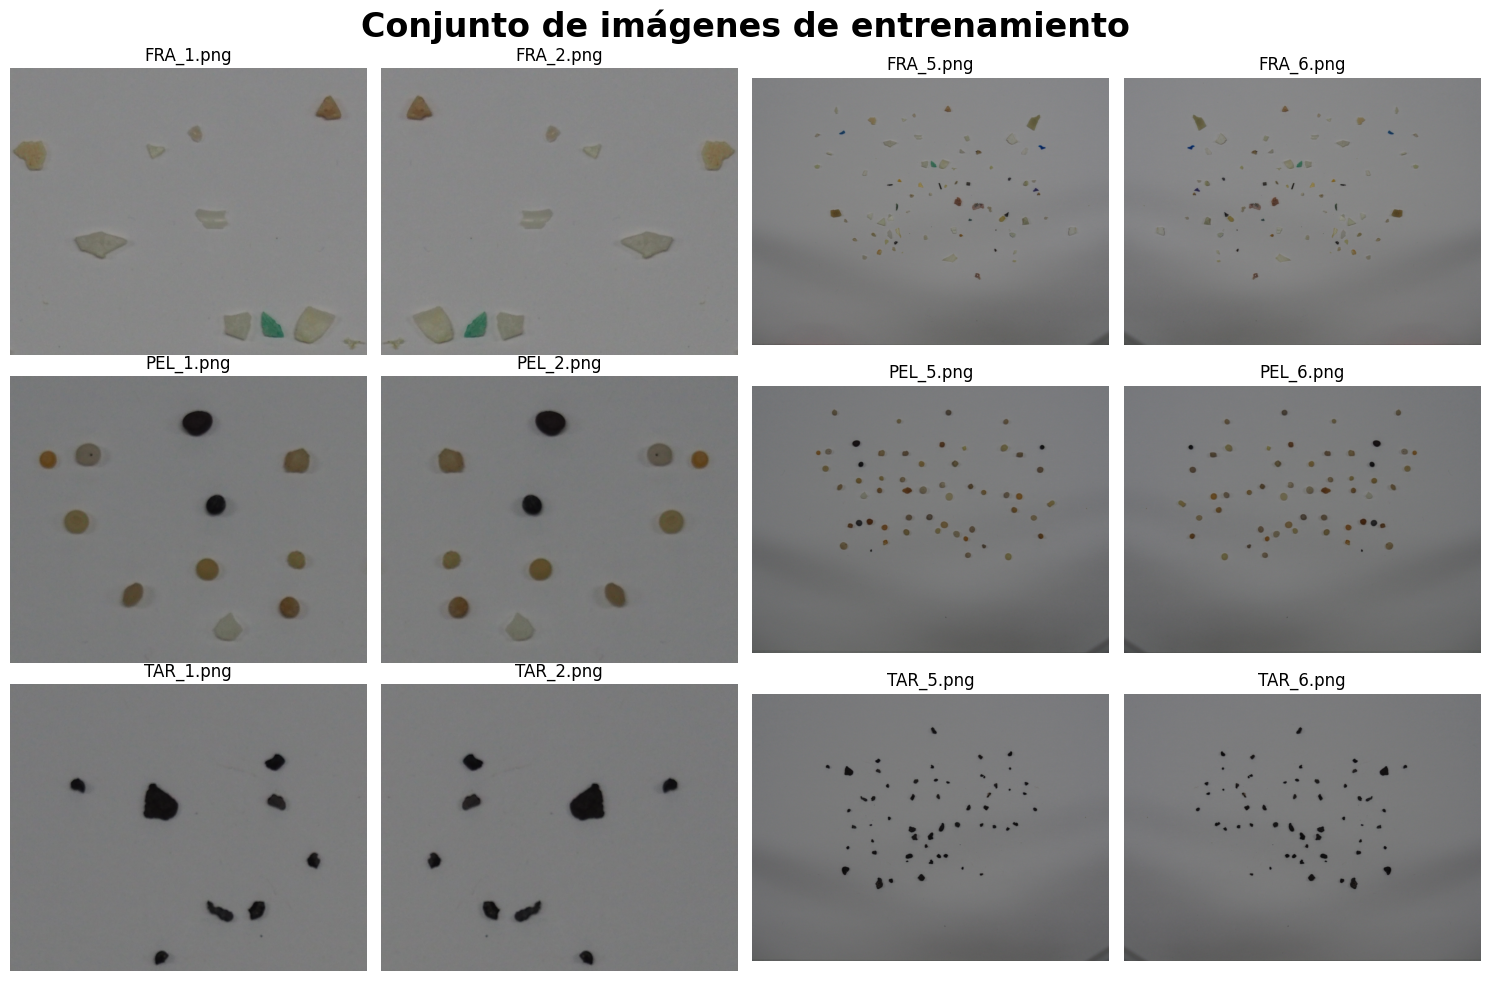

In [71]:
rows = len(image_paths)
cols = 4 
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
plt.suptitle('Conjunto de imágenes de entrenamiento', fontsize=24, fontweight='bold')

for row_idx, (label, paths) in enumerate(image_paths.items()):
    image_files = sorted(Path(output_dir).glob(f"{label}_*.png"))
    
    for col_idx, file_path in enumerate(image_files):
        img_bgr = cv2.imread(str(file_path))

        if img_bgr is not None:
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            ax = axes[row_idx, col_idx]
            ax.imshow(img_rgb)

            ax.set_title(file_path.name, fontsize=12)
            ax.axis('off')

    if len(image_files) < cols:
        for i in range(len(image_files), cols):
            axes[row_idx, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

En cuanto a la extracción de características se realiza un proceso de análisis centrado en la segmentación de los objetos y del cálculo de dos características principales como son el brillo y la circularidad de los objetos, dichas características han sido elegidas teniendo en cuenta que los objetos de tipo **PEL** son circulares y los de tipo **TAR** som muy oscuros. Los pasos seguidos por el __*extract_features*__ son los siguientes:

- Conversión a escala de grises: Después de comprobar si la entrada es no nula convierte la imagen a escala de grises.

- Conversión a HSV (Hue, Saturation, Value).

- Calcular el brillo: Se calcula la media de todos los píxeles del canal V que representa el brillo del objeto (primera de las características a procesar posteriormente).

Una vez obtenida la primera de las características se procede a la segmentación de los objetos mediante la binarización con [OTSU](https://learnopencv.com/otsu-thresholding-with-opencv/) de los mismos:

- Umbralizar: Mediante el método [OTSU](https://learnopencv.com/otsu-thresholding-with-opencv/) se encuentra el umbral óptimo que divide el fondo de los objetos y, tras esto, se invierte el resultado para obtener el fondo negro y los objetos blancos.

- Cierre morfológico: Usando la función __*cv2.MORPH_CLOSE*__ se aplica un cierre morfológico que consiste en una dilatación y una erosión con el propósito de eliminar los pequeños huecos dentro de los objetos y unir áreas cercanas para suavizar los contornos.

Con la binarización realizada, se procede a buscar los contornos de los objetos detectados mediante la función __*cv2.findContours*__.

Como última parte de la función de extracción de características se itera sobre todos los contornos detectados para calcular las propiedades inicializando una serie de acumuladores.

- Iteración y filtrado: Para cada contorno detectado se calcula el área y la longitud del perímetro después de cerrarlo.

- Cálculo de circularidad: Si el perímetro es mayor que cero se utiliza una métrica adimensional que viene dada por la siguiente fórmula (el valor = 1 es un círculo perfecto):

$$
\text{Circularidad} = \frac{4 \pi \cdot \text{Área}}{\text{Perímetro}^2}
$$

Una vez obtenido el valor de la circularidad y teniendo en cuenta todas las muestras del mismo tipo de objeto, se obtiene la media ponderada de la circularidad aplicando la siguiente métrica:

$$
\text{Circularidad con Media Ponderada} = \frac{\sum_i (\text{Circularidad}_i \cdot \text{Área}_i)}{\sum_i \text{Área}_i}
$$

In [72]:
def extract_features(image):
    if image is None or image.size == 0:
        return 0, 0, []
        
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_val = np.mean(hsv[:, :, 2])

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    total_weighted_circularity = 0
    total_area = 0
    valid_contours = []
    min_area_thresh = 100

    for c in contours:
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        
        if area > min_area_thresh:
            valid_contours.append(c)
            total_area += area
            
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter ** 2)
                total_weighted_circularity += circularity * area
    
    if total_area > 0:
        mean_weighted_circularity = total_weighted_circularity / total_area
    else:
        mean_weighted_circularity = 0
            
    return mean_val, mean_weighted_circularity, valid_contours

Se va a mostrar un ejemplo de la detección de los objetos en las imágenes de prueba (una de cada tipo) mediante la aplicación de [Otsu](https://learnopencv.com/otsu-thresholding-with-opencv/) más un filtro de área:

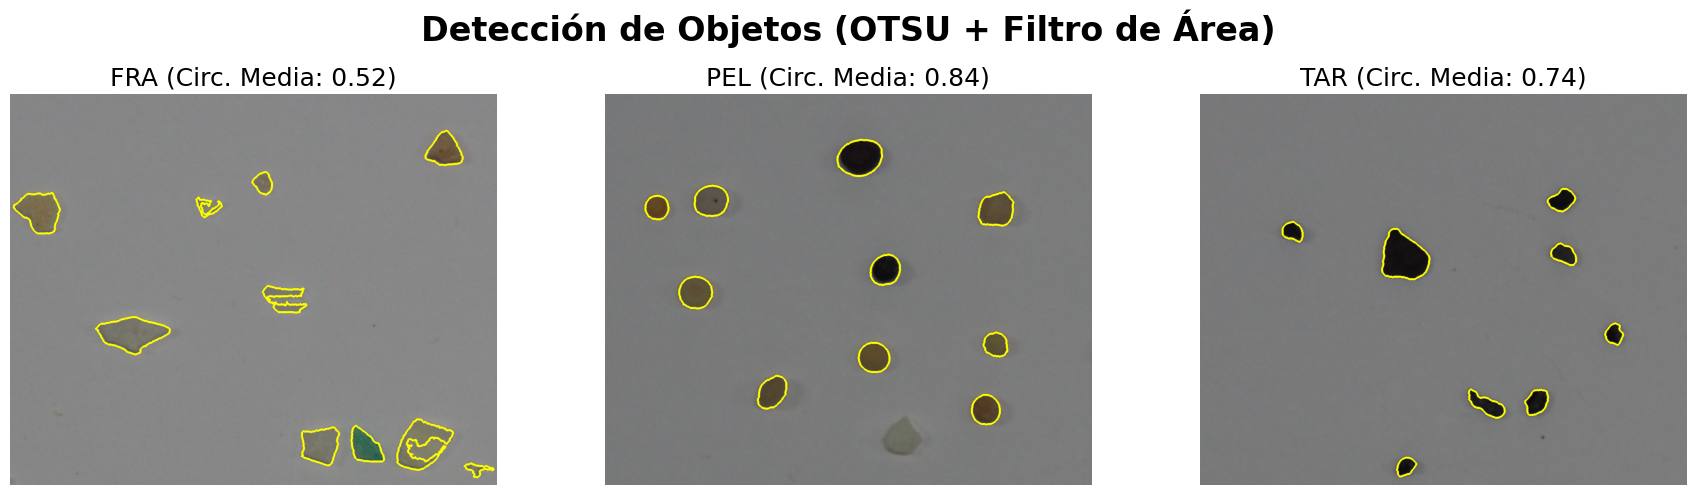

In [73]:
fig, axes = plt.subplots(1, len(image_paths), figsize=(18, 5))
fig.suptitle("Detección de Objetos (OTSU + Filtro de Área)", fontsize=24, fontweight='bold')

for i, (label, paths) in enumerate(image_paths.items()):
    path = paths[0]
    full_path = Path(path)
    
    if full_path.exists():
        img = cv2.imread(str(full_path))
        if img is not None:
            mean_val, circularity, valid_contours = extract_features(img)
            
            vis_img = img.copy()
            
            if valid_contours:
                cv2.drawContours(vis_img, valid_contours, -1, (0, 255, 255), 3)
                
            vis_img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(vis_img_rgb)
            axes[i].set_title(f"{label} (Circ. Media: {circularity:.2f})", fontsize=18)
            axes[i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Ya con las características extraídas se realiza una función llamada __*predict_rules*__ en donde se aplican 3 reglas principales, dos de ellas directamente relacionadas con las características extraídas y otro residual por si los anteriores no aplican:

- Se comprueba la circularidad del objeto y si es mayor al parámetro elegido, entonces el objeto se clasifica como **PEL**.

- En caso de no aplicarse la circularidad, se comprueba el color del objeto, en caso de ser muy oscuro (menor o igual al parámetro elegido) se clasifica como **TAR**.

- Si no se cumple ninguna de las otras reglas, se clasifica automáticamente como **FRA**.

In [74]:
def predict_rules(image, circ_thresh=0.785, val_thresh=182.5): 
    mean_val, circularity, _ = extract_features(image)
    
    if circularity > circ_thresh: 
        return "PEL"
    
    elif mean_val <= val_thresh: 
        return "TAR"
    
    else:
        return "FRA"

Se va a crear un DataFrame con los resultados del clasificador de características para mostrarlos por pantalla.

In [75]:
features_data = []

for label in image_paths.keys():
    image_files = sorted(Path(output_dir).glob(f"{label}_*.png"))
    
    for file_path in image_files:
        
        img = cv2.imread(str(file_path))
        
        if img is not None:
            mean_val, circularity, _ = extract_features(img)

            features_data.append({
                'FileName': file_path.name,
                'Label': label,
                'Mean_Val_HSV': mean_val,
                'Circularity_Weighted': circularity
            })

features_df = pd.DataFrame(features_data)

pd.set_option('display.max_rows', None)     
pd.set_option('display.width', 1000)

print("\n" + "="*3 + " DATAFRAME DE CARACTERÍSTICAS (ENTRENAMIENTO) " + "="*3)
print(features_df.to_string(index=False, float_format="%.3f"))
print("="*52)

pd.reset_option('display.max_rows')
pd.reset_option('display.width')


=== DATAFRAME DE CARACTERÍSTICAS (ENTRENAMIENTO) ===
 FileName Label  Mean_Val_HSV  Circularity_Weighted
FRA_1.png   FRA       135.095                 0.520
FRA_2.png   FRA       135.095                 0.520
FRA_5.png   FRA       127.926                 0.087
FRA_6.png   FRA       127.926                 0.087
PEL_1.png   PEL       120.909                 0.836
PEL_2.png   PEL       120.909                 0.836
PEL_5.png   PEL       116.961                 0.094
PEL_6.png   PEL       116.961                 0.094
TAR_1.png   TAR       120.866                 0.741
TAR_2.png   TAR       120.866                 0.741
TAR_5.png   TAR       117.510                 0.752
TAR_6.png   TAR       117.510                 0.752


Por último se procede a la evaluación del clasificador sobre la imagen del conjunto de pruebas y respaldando los resultados con el resultado real dentro del [csv](../VC_P3/Resources/Task2/MPs_test_bbs.csv), para ello, se realiza un recorte de [ROI (Región de Interés)](https://www.investopedia.com/terms/r/returnoninvestment.asp) y se calculan los resultados mediante una métrica de rendimiento basado en la la comparación de datos obtenidos con los reales.

Aicionalmente, se muestra la precisión obtenida, la imagen con los objetos indentificados con diferentes colores sobre la imagen de prueba y una matriz de confusión con color azul y diferentes grados de tonalidad dependiendo de la saturación de muestras obtenidas.

Accuracy (Clasificación basada en Reglas): 71.13%

================ DATAFRAME DE PREDICCIONES (Muestra) ================
 Index_ROI True_Label Pred_Label  Mean_Val_HSV  Circularity_Weighted
         0        TAR        TAR       171.986                 0.000
         1        TAR        TAR       141.519                 0.783
         2        TAR        TAR       136.651                 0.746
         3        TAR        TAR       180.004                 0.739
         4        TAR        PEL       202.824                 0.807
         5        TAR        FRA       208.616                 0.465
         6        TAR        TAR       169.361                 0.767
         7        TAR        TAR       169.102                 0.694
         8        TAR        FRA       189.704                 0.619
         9        TAR        TAR       176.127                 0.596


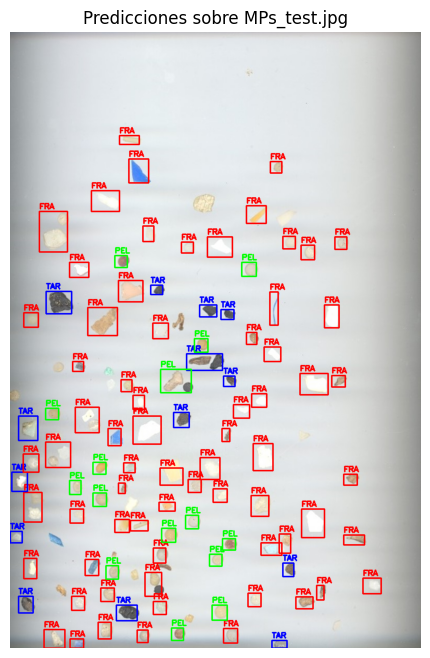

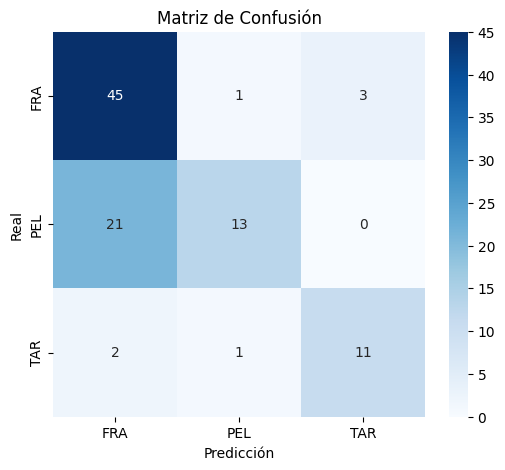

In [76]:
test_img = cv2.imread(test_image_path)
bbs = pd.read_csv(test_csv_path)

y_true, y_pred = [], []
df_data = []

for idx, row in bbs.iterrows():
    x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    label = row['label'].strip().upper()

    y1, y2 = max(0, y1), min(test_img.shape[0], y2)
    x1, x2 = max(0, x1), min(test_img.shape[1], x2)

    roi = test_img[y1:y2, x1:x2]
    if roi.size == 0 or roi.shape[0] <= 1 or roi.shape[1] <= 1:
        continue

    mean_val, circularity, _ = extract_features(roi)
    pred = predict_rules(roi)
    
    y_true.append(label)
    y_pred.append(pred)
    
    df_data.append({
        'Index_ROI': idx,
        'True_Label': label,
        'Pred_Label': pred,
        'Mean_Val_HSV': mean_val,
        'Circularity_Weighted': circularity
    })

target_labels = ["FRA", "PEL", "TAR"]
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred, labels=target_labels)
results_df = pd.DataFrame(df_data)

print(f"Accuracy (Clasificación basada en Reglas): {acc*100:.2f}%")

print("\n" + "="*16 + " DATAFRAME DE PREDICCIONES (Muestra) " + "="*16)
print(results_df.head(10).to_string(index=False, float_format="%.3f"))
print("="*69)

color_map = {"FRA": (0, 0, 255), "PEL": (0, 255, 0), "TAR": (255, 0, 0)}
vis_img = test_img.copy()

for i, row in bbs.iterrows():
    if i >= len(y_pred):
        continue
    x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    
    x1, y1, x2, y2 = max(0, x1), max(0, y1), min(vis_img.shape[1], x2), min(vis_img.shape[0], y2)
    
    label_pred = y_pred[i]
    color = color_map.get(label_pred, (255, 255, 255))
    cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(vis_img, label_pred, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title("Predicciones sobre MPs_test.jpg")
plt.axis("off")
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

## Fuentes y Documentación

- **Internet:** Se ha utilizado internet para la búsqueda de información acerca de la segmentación y diferentes métricas y características para aplicar las diferentes técnicas ([SMACC: A System for Microplastics Automatic Counting and Classification](https://ieeexplore.ieee.org/document/8976153)) con el objetivo de mejorar la precisión del modelo ejecutado en la [tarea2](#tarea-2). Además, se han buscado los *"emojis"* para los mensajes de creación de imagenes en dicha tarea.

- **Inteligencia Artificial Generativa (ChatGPT, Gemini):** Se ha utilizado la IA para intentar mejorar la precisión del modelo de obtención de características (desempeño nulo/deficiente de los resultados obtenidos con la IA).

- **Enlaces:**
    - https://ieeexplore.ieee.org/document/8976153
    - https://learnopencv.com/otsu-thresholding-with-opencv/
    - https://chatgpt.com/
    - https://gemini.google.com
    - https://www.investopedia.com/terms/r/returnoninvestment.asp

Para más documentación referente a las tareas, véase el [README](./README.md) asociado a la carpeta de la práctica en cuestión **(VC_P3)**.